In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print("Started!")

Started!


In [2]:
gender_columns = ["female_defendant", "female_petitioner", "female_adv_def", "female_adv_pet"]

def gender_to_int(x):
    return int(str(x).split()[0])

def get_year_cases(year):
    fields = ["ddl_case_id", "year", "state_code", "female_defendant", "female_petitioner", "female_adv_def", "female_adv_pet", "disp_name", "date_of_filing", "date_of_decision", "date_first_list",
       "date_last_list", "date_next_list"]
    
    cases = pd.read_csv(f"csv/cases/cases/cases_{year}.csv", usecols=fields) # , nrows=10000
    
    # normalise gender columns to ints (apparently only female_defendant col has strings, but still)
    for gc in gender_columns:
        cases[gc] = cases[gc].apply(gender_to_int)
        print(cases[gc].unique())

    return cases

In [3]:
state_key = pd.read_csv("csv/keys/keys/cases_state_key.csv")

def get_state_code_to_name(year):
    state_code_to_name = {}
    
    for ind in state_key.index:
        if state_key.year[ind] == year:
            state_code_to_name[state_key.state_code[ind]] = state_key.state_name[ind]
            
    return state_code_to_name

In [4]:
def get_good_disp(cases):
    # might wanna add: , 'bail granted', 'bail refused', 'bail rejected'
    return cases.loc[cases.disp_name.isin(['allowed', 'dismissed', 'convicted', 'plea bargaining', 'reject', 'plead guilty', 'withdrawn', 'acquitted', 'confession', 'settled', 'died'])] # select some cute dispositions


In [5]:
def process_dates_and_filter(cases):
    # print("- Undecided cases:", cases.date_of_decision.isna().sum())
    date_columns = ["date_of_filing", "date_of_decision", "date_first_list", "date_next_list"]
    for date_col in date_columns:
        cases[date_col] = pd.to_datetime(cases[date_col], errors="coerce")

    cases = cases.dropna(subset=date_columns)

    cases.loc[:,"duration"] = (cases.date_of_decision - cases.date_of_filing).dt.days + 1
    # return cases
    return cases.loc[(cases.duration > 0) & (cases.date_of_decision <= pd.to_datetime("2022-12-31"))]

In [6]:
judge_case_key = pd.read_csv("csv/keys/keys/judge_case_merge_key.csv")

def merge_judge_data(cases):
    return pd.merge(cases, judge_case_key, on="ddl_case_id", how="left")

In [7]:
def describe_durations_by_disp(cases):
    for disp_name in cases.disp_name.unique():
        print("\n\n----------------", disp_name, sep="\n")
        print(cases.loc[cases.disp_name == disp_name].duration.describe())

In [8]:
disp_key = pd.read_csv("csv/keys/keys/disp_name_key.csv")

def merge_disp_name(cases, year):
    cases = pd.merge(cases, disp_key[["year", "disp_name", "disp_name_s"]], on=["year", "disp_name"], how="left")
    cases.disp_name = cases.disp_name_s
    return cases.drop(columns="disp_name_s")

In [9]:
working_year_cases = []
working_year = 2016

for year in range(2016, 2015, -1):
    print("\n----------------------")
    print("Beginning", year, "-------")
    print("----------------------")
    
    cases = get_year_cases(year)
    date_processed_cases = process_dates_and_filter(cases)
    print("- ", round(100 - 100 * (date_processed_cases.shape[0] / cases.shape[0])), "% cases were removed due to invalid dates or undecidedness", sep="")
    print("- Working with", date_processed_cases.shape[0], "cases") 
    cases = merge_disp_name(date_processed_cases, year)
    print("- Merged dispositions")
    # cases = get_good_disp(cases)
    # print(cases.head())
    
    if working_year == year:
        working_year_cases = cases.copy()
    
    # sns.catplot(x="duration", y="disp_name", data=cases, kind="box", aspect=1.5).set(title=f"Disposition duration boxplot, {year}")
    # sns.displot(data=cases, x="duration", hue="disp_name", multiple="stack", kind="kde", aspect=4).set(title=f"Disposition duration distribution, {year}")
    # describe_durations_by_disp(cases)
    
cases = working_year_cases


----------------------
Beginning 2016 ------------
----------------------
[    0 -9998     1 -9999]
[-9999     1     0 -9998]
[    0     1 -9998 -9999]


/tmp/ipykernel_11836/2492024135.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases.loc[:,"duration"] = (cases.date_of_decision - cases.date_of_filing).dt.days + 1


- 31% cases were removed due to invalid dates or undecidedness
- Working with 7833919 cases
- Merged dispositions


Talk about how (plead-guilty + confession - explain why same), convicted, and reject have very small means.

In [10]:
cases = merge_judge_data(cases)

In [11]:
cases_diff_judge = cases.loc[(~cases.ddl_decision_judge_id.isnull()) & (cases.ddl_filing_judge_id != cases.ddl_decision_judge_id)]
cases_same_judge = cases.loc[(~cases.ddl_decision_judge_id.isnull()) & (cases.ddl_filing_judge_id == cases.ddl_decision_judge_id)]

print("Diff:", cases_diff_judge.shape[0], ", Same:", cases_same_judge.shape[0], ", Other Cases:", cases.shape[0] - cases_diff_judge.shape[0] - cases_same_judge.shape[0])

Diff: 440658 , Same: 1048282 , Other Cases: 6344979


In [12]:
print(cases_diff_judge.duration.describe())
print("----")
print(cases_same_judge.duration.describe())

count   440658.000
mean       511.342
std        288.919
min          1.000
25%        277.000
50%        505.000
75%        734.000
max       1450.000
Name: duration, dtype: float64
----
count   1048282.000
mean         87.810
std         150.405
min           1.000
25%           5.000
50%          19.000
75%          97.000
max        1447.000
Name: duration, dtype: float64


On an average, cases with different filing and decision judges take much longer to complete.

In [13]:
cases = pd.merge(cases, state_key[["year", "state_code", "state_name"]], on=["year", "state_code"], how="left")
cases.head()

# Goa has 1 case, let's drop
# cases = cases.loc[cases.state_name != "Goa"]

print(cases.columns)

Index(['ddl_case_id', 'year', 'state_code', 'female_defendant',
       'female_petitioner', 'female_adv_def', 'female_adv_pet', 'disp_name',
       'date_of_filing', 'date_of_decision', 'date_first_list',
       'date_last_list', 'date_next_list', 'duration', 'ddl_filing_judge_id',
       'ddl_decision_judge_id', 'state_name'],
      dtype='object')


In [14]:
state_duration_means = []

for state_name in cases.state_name.unique():
    duration_mean = cases.loc[cases.state_name == state_name].duration.mean()
    state_duration_means.append({"state_name": state_name, "duration_mean": duration_mean})
    

state_case_agg = pd.DataFrame(state_duration_means)
state_case_agg.sort_values(by="duration_mean", inplace=True)
state_case_agg

,state_name,duration_mean
23,Sikkim,99.396
24,Manipur,120.821
20,Meghalaya,127.986
29,Diu and Daman,178.591
2,Karnataka,191.993
16,Gujarat,195.205
17,Chhattisgarh,214.836
28,Goa,220.071
22,Madhya Pradesh,234.041
13,Haryana,236.386


In [15]:
judges = pd.read_csv("csv/judges_clean.csv")
judges = pd.merge(judges, state_key[["state_code", "state_name"]], on=["state_code"], how="left")

In [16]:
judges.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,state_name
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
1,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
2,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
3,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
4,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra


In [17]:
state_case_agg["judges"] = 0
state_case_agg["cases"] = 0
state_case_agg["cases/judges"] = 0

for state_name in judges.state_name.unique():
    judge_count = judges.loc[judges.state_name == state_name].shape[0]
    case_count = cases.loc[cases.state_name == state_name].shape[0]
    state_case_agg.loc[state_case_agg.state_name == state_name, ["judges", "cases", "cases/judges"]] = judge_count, case_count, case_count / judge_count

In [18]:
state_case_agg

,state_name,duration_mean,judges,cases,cases/judges
23,Sikkim,99.396,1503,5011,3.334
24,Manipur,120.821,1017,13635,13.407
20,Meghalaya,127.986,1332,4343,3.261
29,Diu and Daman,178.591,0,0,0.000
2,Karnataka,191.993,61335,825655,13.461
16,Gujarat,195.205,66249,593281,8.955
17,Chhattisgarh,214.836,9360,132049,14.108
28,Goa,220.071,3033,25296,8.340
22,Madhya Pradesh,234.041,50661,496729,9.805
13,Haryana,236.386,21042,482280,22.920


In [19]:
# Add population information to the DataFrame

population = {
    "Uttar Pradesh": 199812341,
    "Maharashtra": 112374333,
    "Bihar": 104099452,
    "West Bengal": 91276115,
    "Madhya Pradesh": 72626809,
    "Tamil Nadu": 72147030,
    "Rajasthan": 68548437,
    "Karnataka": 61095297,
    "Gujarat": 60439692,
    "Andhra Pradesh": 49577103,
    "Orissa": 41974219,
    "Telangana": 35003674,
    "Kerala": 33406061,
    "Jharkhand": 32988134,
    "Assam": 31205576,
    "Punjab": 27743338,
    "Chhattisgarh": 25545198,
    "Haryana": 25353081,
    "Jammu and Kashmir": 12541302,
    "Uttarakhand": 10086292,
    "Himachal Pradesh": 6864602,
    "Tripura": 3673917,
    "Meghalaya": 2966889,
    "Manipur": 2721756,
    "Nagaland": 1978502,
    "Goa": 1458545,
    "Arunachal Pradesh": 1383727,
    "Mizoram": 1091014,
    "Sikkim": 607688,
    "Delhi": 16753235,
    "Puducherry": 1244464,
    "Chandigarh": 1054686,
    "Andaman and Nicobar Islands": 380581,
    "DNH at Silvasa": 342853,
    "Diu and Daman": 243247,
    "Lakshadweep": 64429
}

state_case_agg["population"] = 0
state_case_agg = state_case_agg[~state_case_agg.state_name.isin(["Ladakh", "DNH at Silvasa", "Diu and Daman"])]

for state_name in state_case_agg.state_name.unique():
    state_case_agg.loc[state_case_agg.state_name == state_name, "population"] = population[state_name]
    
state_case_agg.head()

,state_name,duration_mean,judges,cases,cases/judges,population
23,Sikkim,99.396,1503,5011,3.334,607688
24,Manipur,120.821,1017,13635,13.407,2721756
20,Meghalaya,127.986,1332,4343,3.261,2966889
2,Karnataka,191.993,61335,825655,13.461,61095297
16,Gujarat,195.205,66249,593281,8.955,60439692


In [20]:
state_case_agg["population/cases"] = state_case_agg.population / state_case_agg.cases
state_case_agg.sort_values(by="population/cases", inplace=True)
state_case_agg

/tmp/ipykernel_11836/3714194711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_case_agg["population/cases"] = state_case_agg.population / state_case_agg.cases
/tmp/ipykernel_11836/3714194711.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_case_agg.sort_values(by="population/cases", inplace=True)


,state_name,duration_mean,judges,cases,cases/judges,population,population/cases
26,Chandigarh,315.846,1260,25921,20.572,1054686,40.688
13,Haryana,236.386,21042,482280,22.920,25353081,52.569
3,Kerala,287.072,27963,604141,21.605,33406061,55.295
28,Goa,220.071,3033,25296,8.340,1458545,57.659
25,Delhi,315.339,13464,228229,16.951,16753235,73.405
2,Karnataka,191.993,61335,825655,13.461,61095297,73.996
21,Punjab,269.553,17469,372329,21.314,27743338,74.513
4,Himachal Pradesh,241.087,8235,76550,9.296,6864602,89.675
16,Gujarat,195.205,66249,593281,8.955,60439692,101.874
23,Sikkim,99.396,1503,5011,3.334,607688,121.271


/tmp/ipykernel_11836/2825199371.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(state_case_agg.corr(), cmap="YlGnBu", annot=True)


<AxesSubplot:>

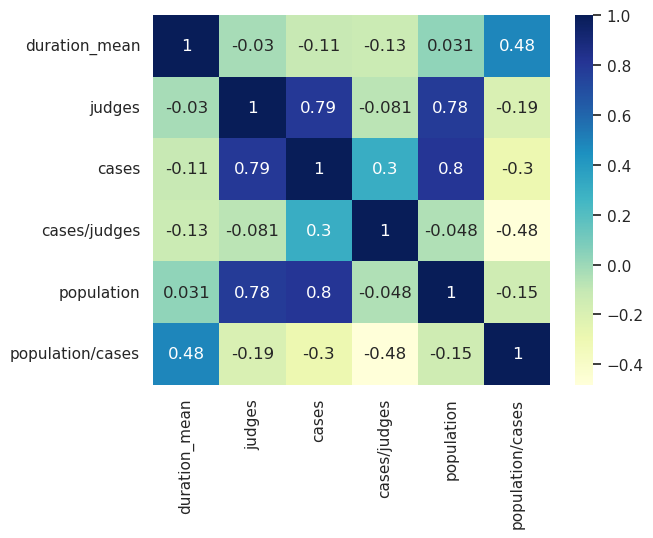

In [21]:
sns.heatmap(state_case_agg.corr(), cmap="YlGnBu", annot=True)

This shows a significant correlation between the population, the number of cases, and the number of judges in a state. The population and the mean duration of cases in a state also seem to be considerably positively correlated. 

Interestingly, it also shows a moderate negative correlation between the ratio `cases/judges` and the mean duration of cases. This might be counter-intuitive, TODO: but explain why.

In [22]:
judges.head()

,ddl_judge_id,state_code,dist_code,court_no,judge_position,female_judge,start_date,end_date,state_name
0,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
1,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
2,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
3,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra
4,1,1,1,1,chief judicial magistrate,0 nonfemale,20-09-2013,20-02-2014,Maharashtra


/tmp/ipykernel_11836/977081547.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  judges[dc] = pd.to_datetime(judges[dc], errors="coerce")
/tmp/ipykernel_11836/977081547.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  judges[dc] = pd.to_datetime(judges[dc], errors="coerce")


Removed 49% judges
count   450810.000
mean       583.965
std        500.405
min          2.000
25%        215.000
50%        462.000
75%        862.000
max       7728.000
Name: duration, dtype: float64


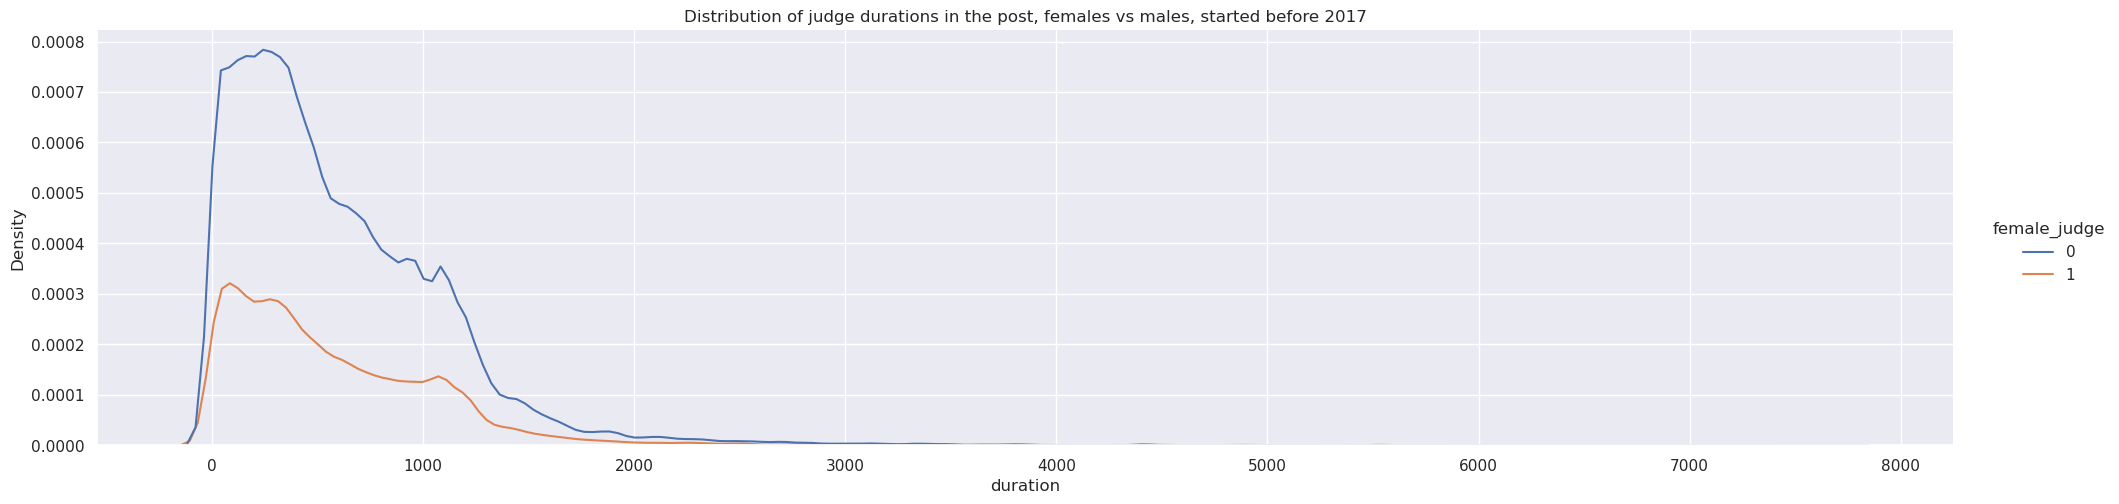

     state_code  male_duration  female_duration  m_-_f_duration  judges  \
0             7        546.920          785.798        -238.877   12105   
9            19        582.625          675.571         -92.946     198   
18           21        535.389          623.271         -87.882     594   
27           25        591.848          679.500         -87.652     495   
36           27        828.545          907.000         -78.455     756   
45            6        680.044          723.373         -43.329    7191   
54           18        697.519          731.000         -33.481    5175   
63            5        659.986          692.854         -32.868    4995   
72            2        615.324          644.303         -28.979   16659   
81            8        653.746          680.362         -26.616   13140   
90           26        740.796          760.800         -20.004    4257   
99           23        804.604          822.430         -17.826   26730   
108           3        52

In [23]:
def analyse_judges(judges):
    init_judge_ct = judges.shape[0]
    
    # filter for only judges with known genders AND started atmost 2016
    judges = judges.copy()[judges.female_judge.notna()]
    judges.female_judge = judges.female_judge.apply(gender_to_int)
    judges = judges.loc[(judges.female_judge == 0) | (judges.female_judge == 1)]
    
    date_columns = ["start_date", "end_date"]
    for dc in date_columns:
        judges[dc] = pd.to_datetime(judges[dc], errors="coerce")
    
    judges["duration"] = (judges.end_date - judges.start_date).dt.days + 1
    judges = judges[(judges.duration >= 1) & (judges.start_date <= pd.to_datetime("01/01/2017"))]
        
    fin_judge_ct = judges.shape[0]
    print("Removed ", round(100 - 100 * fin_judge_ct / init_judge_ct), "% judges", sep="")
    
    print(judges.duration.describe())
    sns.displot(x="duration", hue="female_judge", data=judges, kind="kde", aspect=4).set(title="Distribution of judge durations in the post, females vs males, started before 2017")
    plt.show()
    
    state_judges_data = []
    for state_code in judges.state_code.unique():
        curr_state_judges = judges.loc[judges.state_code == state_code]
        male_duration_mean = curr_state_judges.loc[judges.female_judge == 0].duration.mean()
        female_duration_mean = curr_state_judges.loc[judges.female_judge == 1].duration.mean()
        judge_count = curr_state_judges.shape[0]
        
        data = {"state_code": state_code, "male_duration": male_duration_mean, "female_duration": female_duration_mean, "m_-_f_duration": male_duration_mean - female_duration_mean, "judges": judge_count}
        state_judges_data.append(data)
    
    state_judges = pd.DataFrame(state_judges_data)
    state_judges.sort_values(by="m_-_f_duration", inplace=True)
    state_judges = pd.merge(state_judges, state_key[["state_code", "state_name"]], on=["state_code"], how="left").drop_duplicates()
    print(state_judges)
    
    
    
analyse_judges(judges)

Jharkhand and Sikkim appear to be outliers. On an average, a female judge in Jharkhand stays in her position for ~200 more days than a male judge. This stat almost reverses in the case of Sikkim.

In [24]:
# filter judges for known genders
processed_judges = judges.copy()[judges.female_judge.notna()]
processed_judges.female_judge = processed_judges.female_judge.apply(gender_to_int)

judge_id_to_female = {}
    
for ind in processed_judges.index:
    judge_id_to_female[processed_judges.ddl_judge_id[ind]] = processed_judges.female_judge[ind]

print("Built judge ID to gender map")

Built judge ID to gender map


In [25]:
def merge_case_judge_gender(cases):
    # fill decision judge genders
    cases = cases.copy()
    cases["female_decision_judge"] = pd.Series(dtype='int')
    
    cases = pd.merge(cases, processed_judges[["ddl_judge_id", "female_judge"]], left_on="ddl_decision_judge_id", right_on="ddl_judge_id", how="left")
    
    # for ind in cases.index:
    #     judge_id = cases.ddl_decision_judge_id[ind]
    #     if judge_id in judge_id_to_female:
    #         cases.female_decision_judge[ind] = judge_id_to_female[judge_id]
    
    cases.female_decision_judge = cases.female_judge
    cases = cases.drop(columns=["female_judge"])
    cases = cases.dropna(subset=["female_decision_judge"])
    cases["same_gender"] = cases.female_defendant == cases.female_decision_judge
    return cases
        
    
case_judge_gender = merge_case_judge_gender(cases)
# cases.columns

In [26]:
case_judge_gender.corr()

/tmp/ipykernel_11836/3698845632.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  case_judge_gender.corr()


,year,state_code,female_defendant,female_adv_def,female_adv_pet,duration,ddl_filing_judge_id,ddl_decision_judge_id,female_decision_judge,ddl_judge_id,same_gender
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_code,NaN,1.000,0.035,0.010,-0.121,-0.035,0.969,0.969,-0.050,0.969,0.060
female_defendant,NaN,0.035,1.000,-0.040,-0.325,0.280,0.051,0.043,0.022,0.043,0.602
female_adv_def,NaN,0.010,-0.040,1.000,0.180,-0.026,0.023,0.022,-0.091,0.022,0.011
female_adv_pet,NaN,-0.121,-0.325,0.180,1.000,-0.145,-0.117,-0.114,-0.013,-0.114,-0.161
duration,NaN,-0.035,0.280,-0.026,-0.145,1.000,-0.026,-0.030,0.038,-0.030,0.131
ddl_filing_judge_id,NaN,0.969,0.051,0.023,-0.117,-0.026,1.000,1.000,-0.095,1.000,0.064
ddl_decision_judge_id,NaN,0.969,0.043,0.022,-0.114,-0.030,1.000,1.000,-0.088,1.000,0.062
female_decision_judge,NaN,-0.050,0.022,-0.091,-0.013,0.038,-0.095,-0.088,1.000,-0.088,-0.003
ddl_judge_id,NaN,0.969,0.043,0.022,-0.114,-0.030,1.000,1.000,-0.088,1.000,0.062


We check if there's bias regarding gender in assignment of judges to defendants.

In [27]:
print(case_judge_gender.loc[(case_judge_gender.female_defendant == 0) & (case_judge_gender.female_decision_judge == 0)].shape[0] / case_judge_gender.loc[case_judge_gender.female_defendant == 0].shape[0])
print(case_judge_gender.loc[(case_judge_gender.female_defendant == 1) & (case_judge_gender.female_decision_judge == 0)].shape[0] / case_judge_gender.loc[case_judge_gender.female_defendant == 1].shape[0])

0.7013692958044854
0.7044581526832333


There seems to be no such bias.

In [28]:
case_judge_gender = get_good_disp(case_judge_gender)

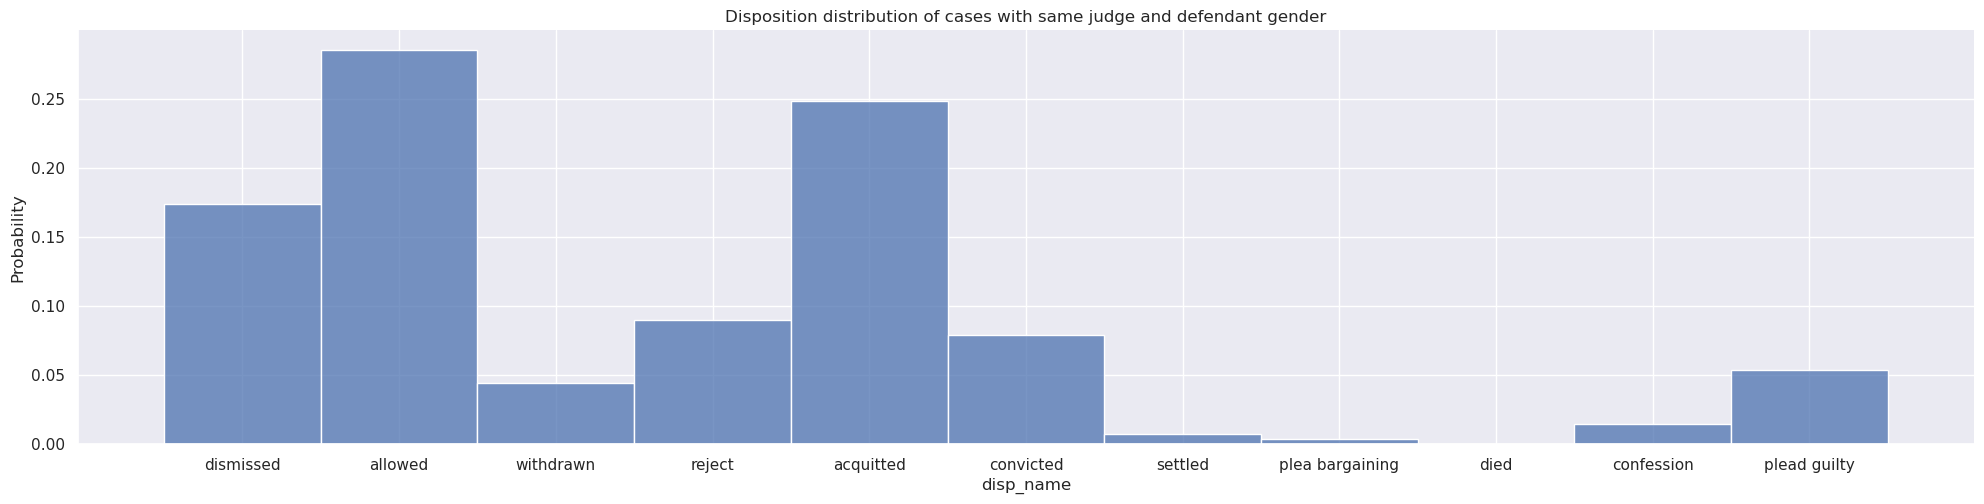

In [29]:
sns.displot(case_judge_gender.loc[case_judge_gender.female_decision_judge == 1], x="disp_name", aspect=4, stat="probability").set(title="Disposition distribution of cases with same judge and defendant gender")

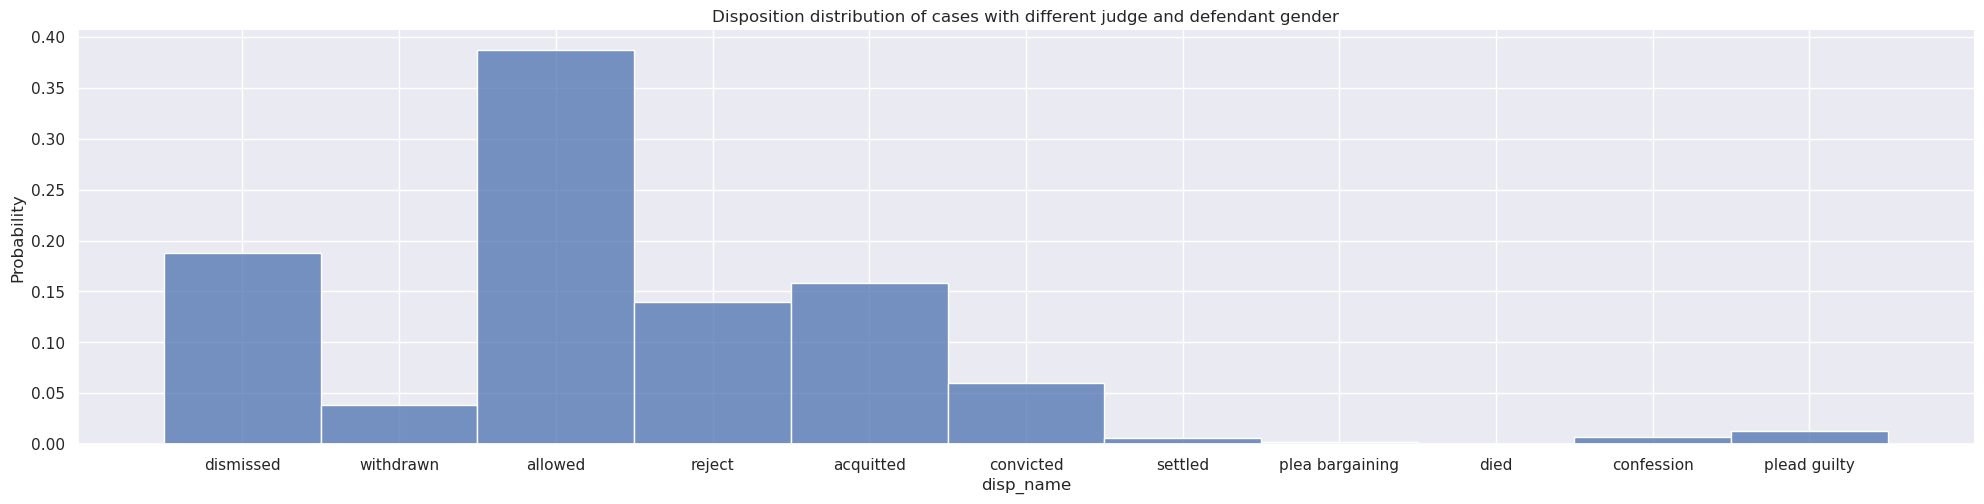

In [30]:
sns.displot(case_judge_gender.loc[case_judge_gender.female_decision_judge == 0], x="disp_name", aspect=4, stat="probability").set(title="Disposition distribution of cases with different judge and defendant gender")

In [8]:
temp = pd.read_csv(f"csv/cases/cases/cases_2015.csv", nrows=10) # , nrows=10000

In [10]:
temp.head()

,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,01-01-01-201908000012015,2015,1,1,1,MHNB030000242015,chief judicial magistrate,-9998 unclear,1 female,-9999,0,1978,6013.000,25,2015-01-01,2015-02-25,2015-01-01,2015-02-16,2015-02-25
1,01-01-01-201908000022015,2015,1,1,1,MHNB030000282015,chief judicial magistrate,0 male,1 female,0,1,1978,5446.000,30,2015-01-02,2016-12-01,2015-01-02,2016-12-01,2016-12-01
2,01-01-01-201908000032015,2015,1,1,1,MHNB030000272015,chief judicial magistrate,0 male,0 male,-9999,0,1978,6013.000,32,2015-01-02,2015-02-25,2015-01-02,2015-02-16,2015-02-25
3,01-01-01-201908000042015,2015,1,1,1,MHNB030000482015,chief judicial magistrate,0 male,0 male,-9999,0,1978,6210.000,51,2015-01-03,2016-03-21,2015-01-03,2016-03-21,2016-03-21
4,01-01-01-201908000052015,2015,1,1,1,MHNB030000332015,chief judicial magistrate,-9998 unclear,0 male,0,0,1978,6013.000,25,2015-01-05,2015-01-12,2015-01-05,2015-01-05,2015-01-12
